**author:** Shikhara Bhat, IISER Pune<br>
**date:** 04 Nov 2021<br>
**purpose:** Compute note co-occurrences for eight species of Spelaeornis birds from Abhinav's data

In [11]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as colors

In [12]:
def make_stochastic_matrix(df):  #Transform a square matrix such that each row sums up to 1

    new_df = np.array(df.copy())
    for i in range(0, len(new_df)):
        row_sum = 0
        for j in range(0, len(new_df[0])):
            if new_df[i][j] == np.inf or pd.isna(new_df[i][j]):
                pass
            else:
                row_sum += new_df[i][j]
        if row_sum != 0:
            new_df[i] = new_df[i] / row_sum

    return pd.DataFrame(new_df)

In [13]:
def get_occurrence_freqs(df,
                            col_name,
                            note_list,
                            win_size,
                            symmetric=False):
    '''
    col_name is the name of the column that contains all the sequences
    note_list is a list that contains the possible values that a note in your sequence can take
    win_size is the window size, which is the maximum distance between two notes that you are looking for
    n is the number of Monte Carlo runs that should be conducted
    '''

    occurrence_vec = np.zeros(len(note_list))
    co_occurrence_matrix = np.zeros((len(note_list), len(note_list)))

    notes = np.array(note_list)
    note_indices = list(np.arange(0, len(note_list), 1))

    for i in range(0, df.shape[0]):  #For each sequence in the dataset
        
        sequence = list(df[col_name][i])

        #for run in range(0, n):  #For each Monte-Carlo run

            #Pick a random index from a uniform(0,len(sequence)-win_size) distribution
            #rand_index = np.random.randint(0, max(len(sequence) - win_size, 1))

            #Generate a random sample using this index value
            #sample = sequence[rand_index:rand_index + win_size]
        
        for note in range(len(sequence)):
            

            if win_size > len(sequence) - 1:
                sample = sequence

            else:
                sample = sequence[note:min(note+win_size,len(sequence))]
                if not len(sample):
                    break

            for i in range(len(sample)):

                note = sample[i]  #For each individual note in the sample

                #Find out which note it is
                try:
                    noteID = int(note_indices[np.where(note == notes)[0][0]])
                except IndexError:
                    continue  #If the note is not in the note_list provided, skip it

                #Add to the occurrence vector
                occurrence_vec[noteID] += 1

                for j in range(0, len(sample)):  #Look at all the other notes in the sample

                    othernote = sample[j]
                    try:
                        othernoteID = int(
                            note_indices[np.where(othernote == notes)[0][0]])

                    except IndexError:
                        continue  #If the note is not in the note_list provided, skip it

                    if symmetric:

                        if noteID == othernoteID and i != j:  #To avoid counting the same note twice, ensure indices are not equal

                            co_occurrence_matrix[noteID][othernoteID] += 1

                        elif noteID != othernoteID:

                            co_occurrence_matrix[noteID][othernoteID] += 1

                    else:

                        if i < j:  #This breaks the symmetry: Only count if note occurred before othernote

                            co_occurrence_matrix[noteID][othernoteID] += 1
                    
                    if win_size > (len(sequence) - 1):
                        break

    for i in range(0, len(note_list)):
        for j in range(0, len(note_list)):
            if occurrence_vec[i] * occurrence_vec[j] != 0:
                co_occurrence_matrix[i][j] = (co_occurrence_matrix[i][j]) / (
                    occurrence_vec[i] * occurrence_vec[j])

    marginal_probs = occurrence_vec / np.sum(
        occurrence_vec)  #Probability of occurrence

    co_occurrence_matrix = make_stochastic_matrix(
        pd.DataFrame(co_occurrence_matrix))

    return co_occurrence_matrix, marginal_probs

In [14]:
def make_new_sequences(df,
                       col_name,
                       notes,
                       marginal_probs):
    #Make a dataframe of random sequences given occurrence probabilities
    '''
    df is a dataframe of sequences
    col_name is the name of the column in df that contains all the sequences
    notes is a list or array that contains the possible values that a note in your sequence can take
    marginal_probs is a list that provides the stationary occurrence probability (frequency) of each note in note_list
    '''

    notes = np.array(notes)
    note_indices = list(np.arange(0, len(notes), 1))
    newdata = []

    cdf_cuts = np.zeros(len(marginal_probs) + 1)
    cdf = 0
    for i in range(1, len(marginal_probs) + 1):
        cdf += marginal_probs[i - 1]
        cdf_cuts[i] = cdf

    cdf_cuts[len(marginal_probs)] = 1

    for index in range(0, df.shape[0]):
        new_seq = ''
        seq_len = len(list(df[col_name][index]))

        for element in range(0, seq_len):
            rd = np.random.uniform()  #Pick a random float between 0 and 1

            for j in range(0,len(cdf_cuts)-1):  #Simulate a stationary distribution

                if cdf_cuts[j] <= rd and rd <= cdf_cuts[j + 1]:
                    note_index = note_indices[j]
                    note = notes[np.where(note_indices == note_index)[0][0]]

            new_seq += str(note)

        newdata.append(new_seq)

    newdata = pd.DataFrame(newdata)
    newdata = newdata.rename(mapper={0: col_name}, axis='columns')

    return newdata

In [15]:
def check_for_co_occurrence(df,
                            col_name,
                            note_list,
                            win_size,
                            #n=10000,
                            runs=100,
                            symmetric=False):

    original_co_occur, marginal_probs = get_occurrence_freqs(
        df, col_name, note_list, win_size, symmetric)

    exp_co_occur = np.zeros((len(note_list), len(note_list)))

    for run in range(runs):
        newdata = make_new_sequences(df, col_name, note_list, marginal_probs)
        new_co_occur = np.array(
            get_occurrence_freqs(newdata, col_name, note_list, win_size, symmetric)[0])

        for i in range(len(note_list)):
            for j in range(len(note_list)):
                exp_co_occur[i][j] += new_co_occur[i][j] / runs

    return original_co_occur, exp_co_occur

In [16]:
def normalized_deviation(obs, exp, max_allowed=5):
    '''
    obs is the dataframe of observed co-occurrences
    exp is the dataframe of expected co-occurrences
    '''

    ratio = np.array(obs / exp)

    #Make all values lie in the open interval [0,max_allowed]
    for i in range(len(ratio)):
        for j in range(len(ratio)):
            if ratio[i][j] > max_allowed:
                ratio[i][j] = max_allowed

            #Prevent small deviations around values like 0/0 from skewing the results
            if abs(obs[i][j] - 0) <= 10**-10 and abs(exp[i][j] - 0) <= 10**-10:
                ratio[i][j] = 1

    return pd.DataFrame(ratio)

In [17]:
def make_heatmap(df,
                 lab,
                 title='',
                 save=False,
                 file='heatmap',
                 cmap='icefire',
                 max_allowed=5):

    import math
    from matplotlib.colors import LogNorm

    fig, ax = plt.subplots(figsize=(12, 7))
    title = title
    plt.title(title, fontsize=18)
    
    #Scale is set to be in the interval [0,max_allowed], centered at 1
    hmap = sns.heatmap(df,
                       xticklabels=lab,
                       yticklabels=lab,
                       cmap=cmap,
                       norm=colors.TwoSlopeNorm(vmin=0,
                                                vcenter=1,
                                                vmax=max_allowed))
    hmap.figure.axes[-1].set_ylabel('observed:expected ratio', size=22)
    

    if save:
        plt.savefig(
            (file + ".svg"),
            dpi=500)  #Save the file as an SVG with a resolution of 500 dpi

    plt.show()

In [19]:
def get_vocab(data,col_name='note sequence'):
    
    vocab = set()
    for i in range(data.shape[0]):
            seq = list(data['note sequence'][i])
            for note in seq:
                vocab.add(note)
    
    return sorted(list(vocab))

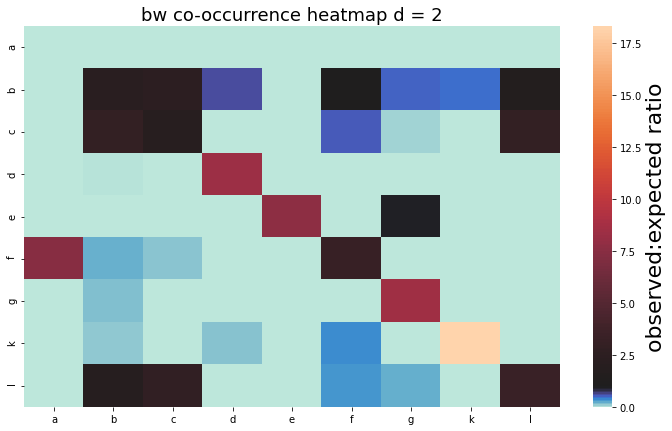

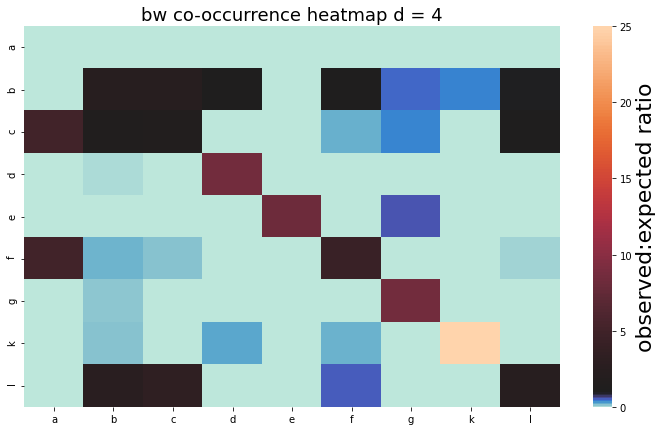

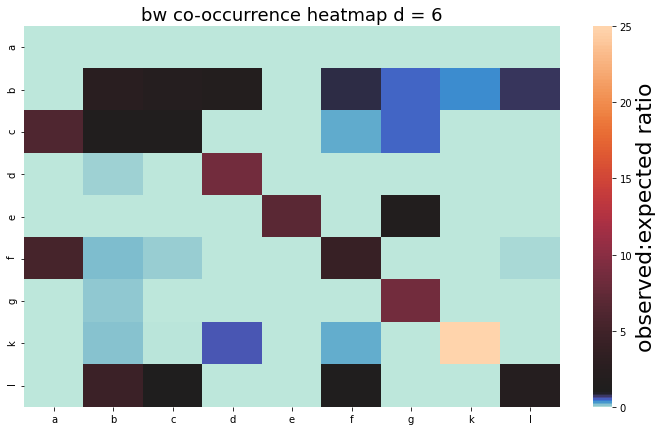

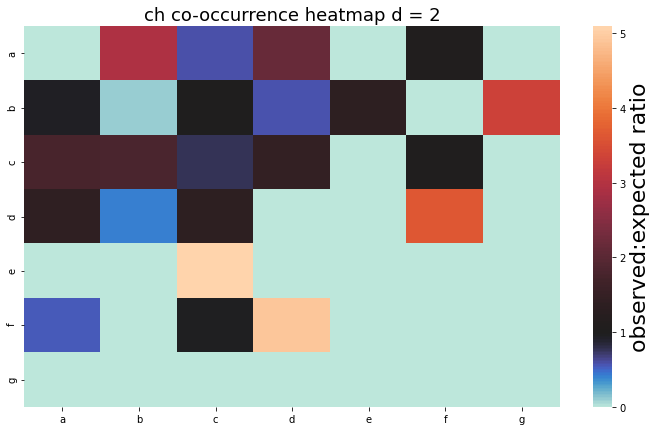

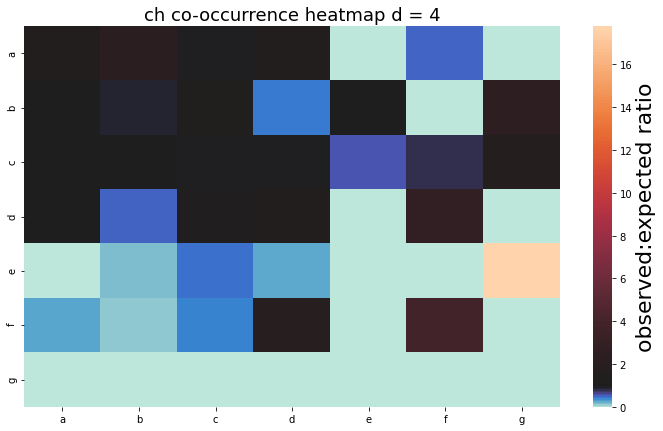

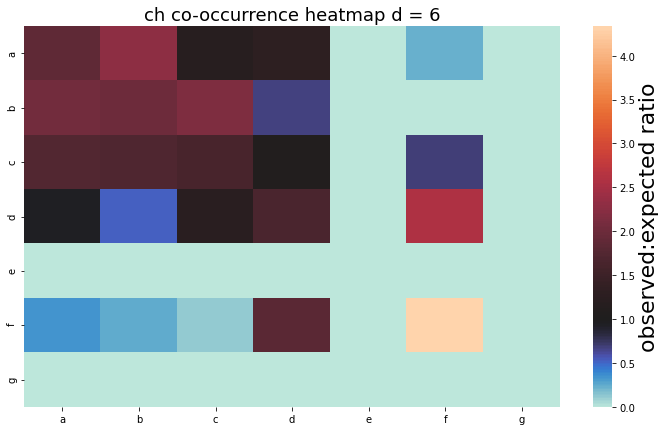

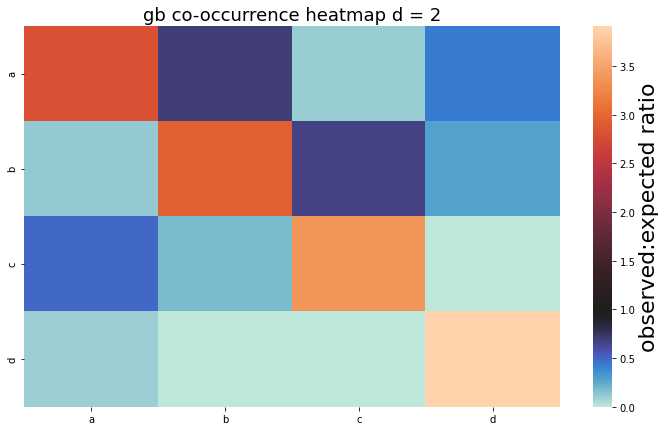

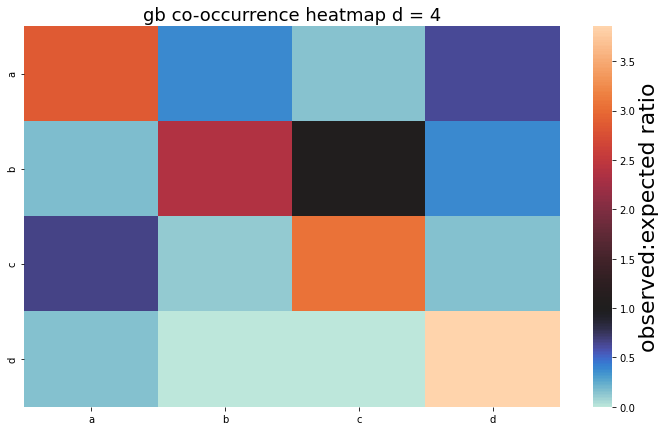

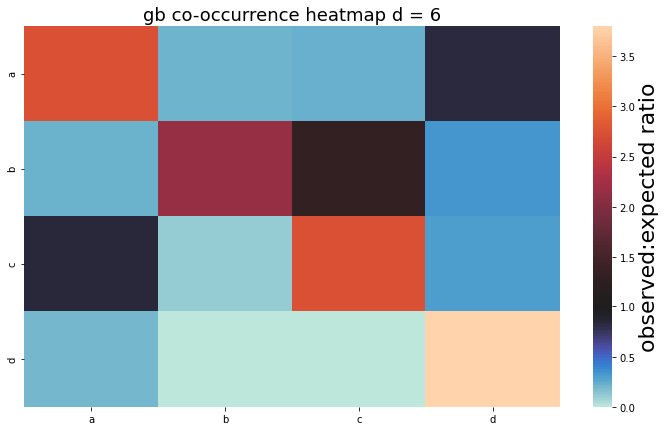

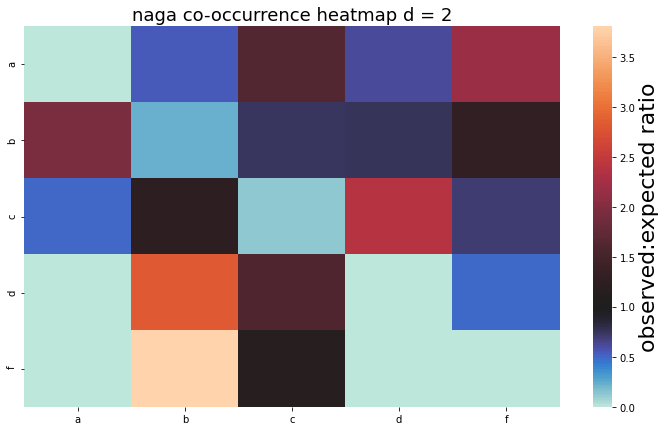

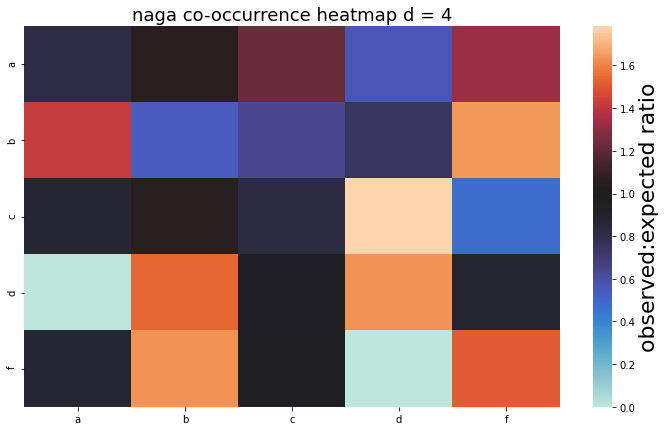

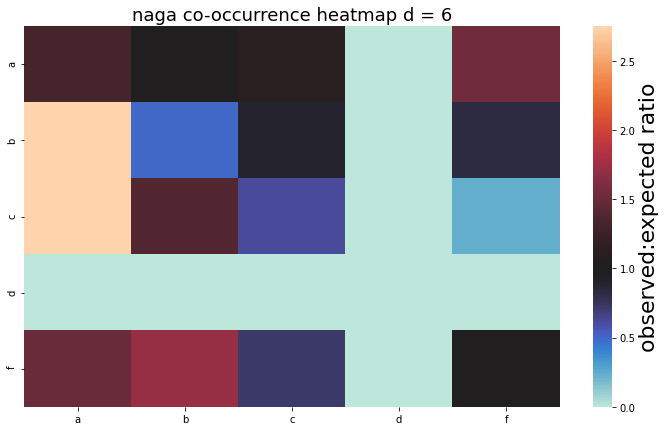

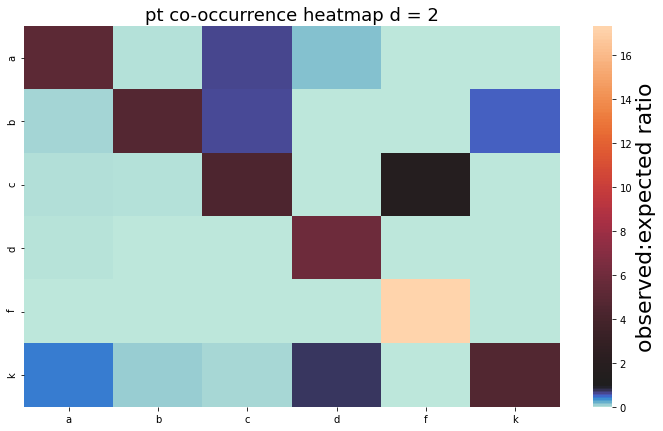

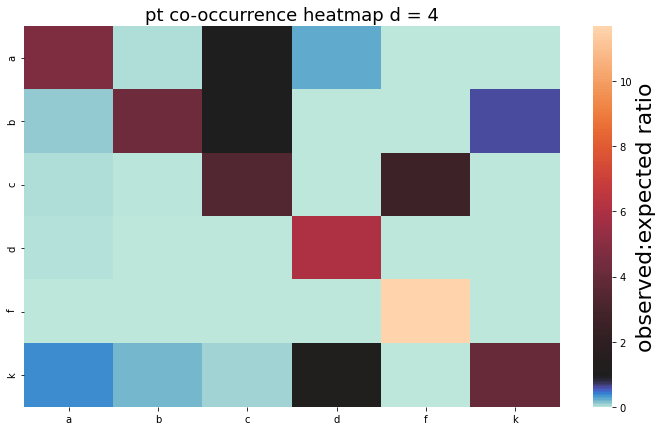

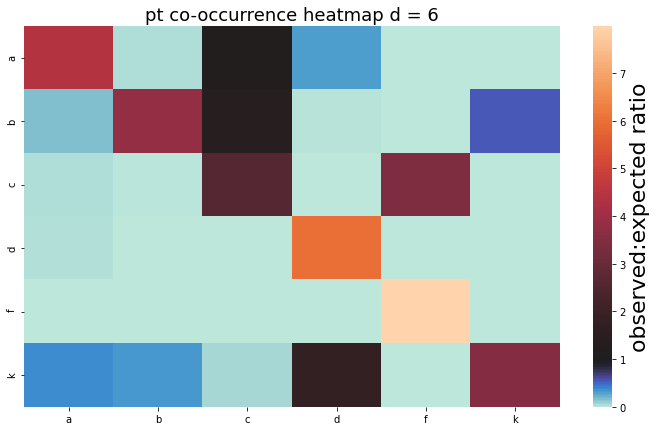

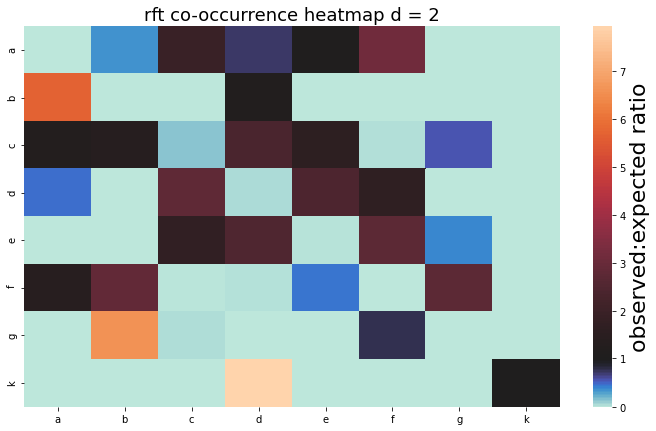

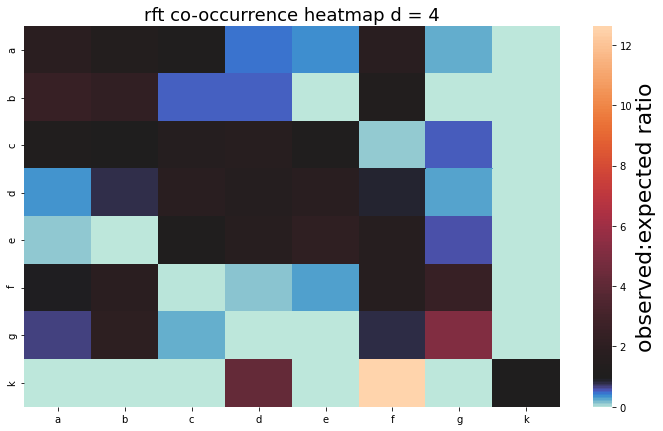

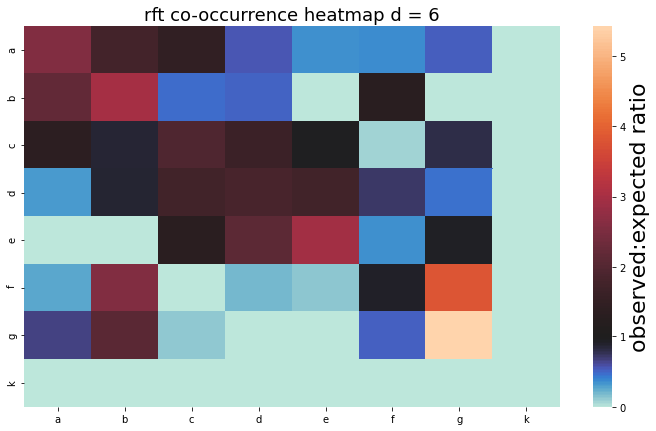

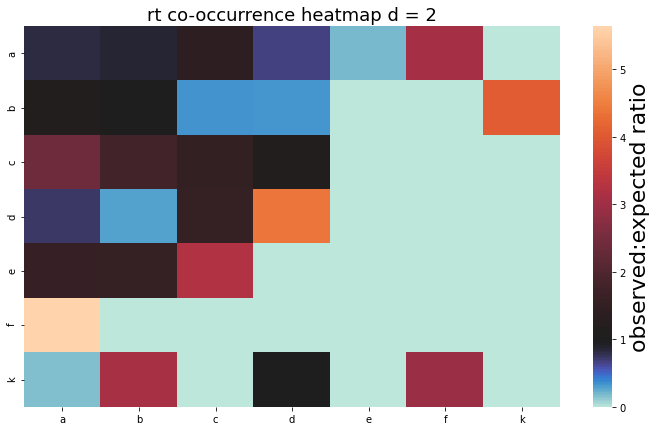

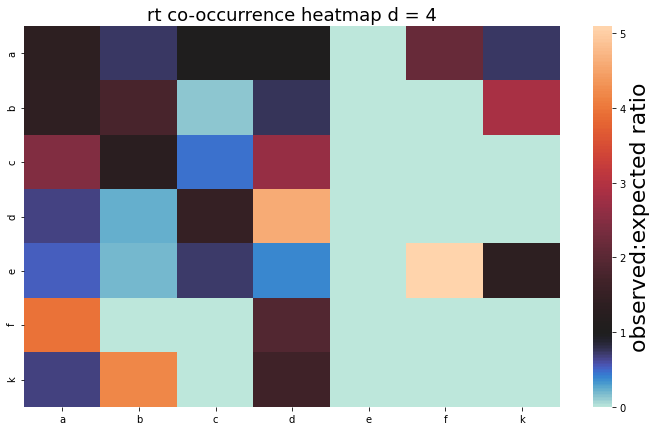

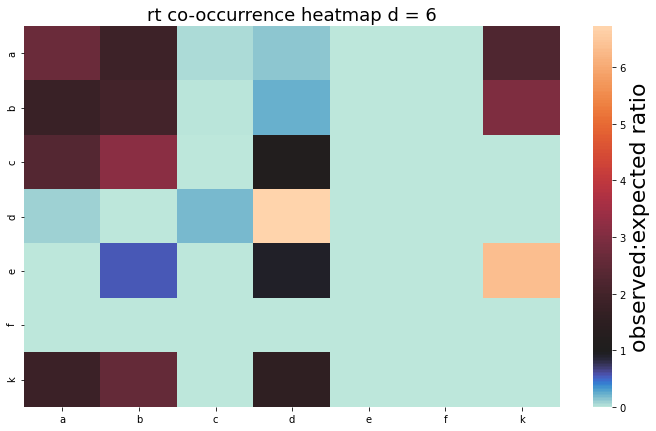

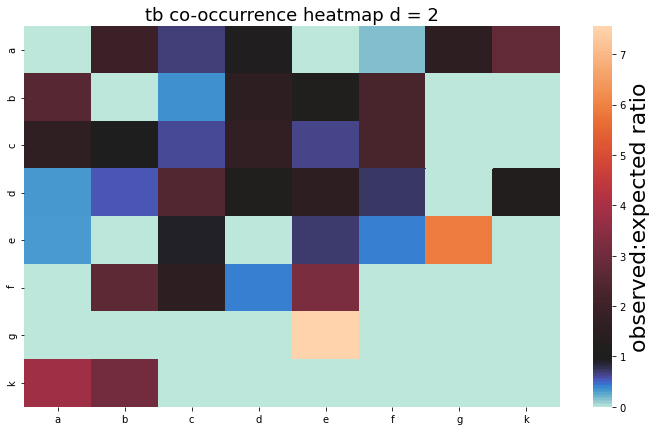

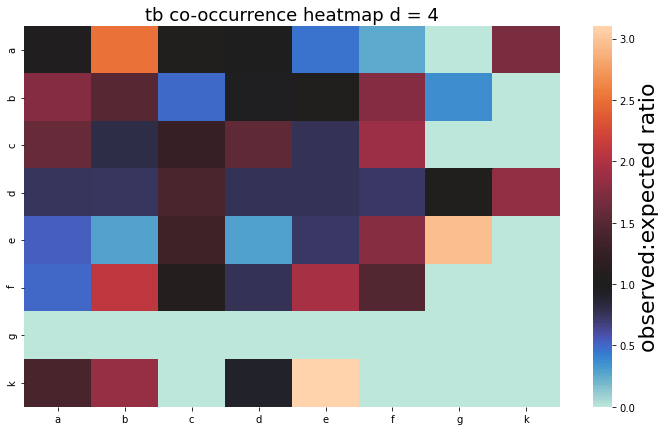

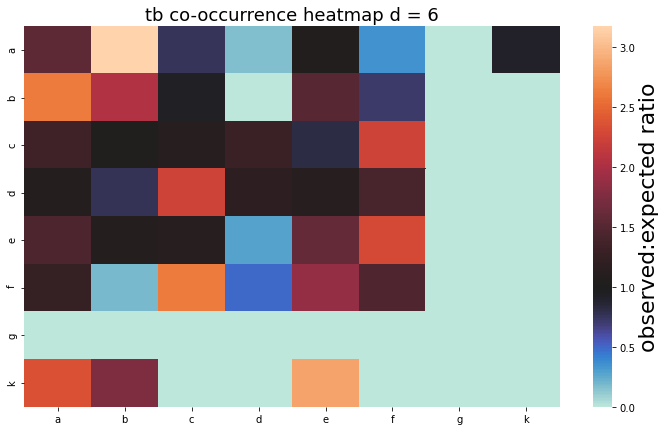

In [20]:
specieslist = ['bw','ch','gb','naga','pt','rft','rt','tb']
winsize_max = 6

common_string = 'Spelaeornis Project - ' 
for species in specieslist:
    
    species_csv = common_string + species + ' noteshare seq.csv' 
    dat = pd.read_csv(species_csv)
    note_list = get_vocab(dat)
    
    for win in range(round(winsize_max/3),winsize_max+1,round(winsize_max/3)): #Take three possible d values
        obs, exp = check_for_co_occurrence(dat,
                                       col_name='note sequence',
                                       note_list=get_vocab(dat),
                                       win_size=win,
                                       runs=500,
                                       symmetric=False)
    
        max_allowed = min(25,max((normalized_deviation(obs, exp, np.inf)).max()))

        make_heatmap(normalized_deviation(obs, exp, max_allowed),
                 get_vocab(dat),
                 max_allowed=max_allowed,
                 title=species+' co-occurrence heatmap ' + 'd = ' + str(win),
                 save=True,
                 file = 'heatmaps/'+species+'_heatmap_'+'d_'+str(win)) #You need to create a folder called 'heatmaps' first